In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
featureMapsNumber = 300
featureMapKernelSize = 3

maxPoolingStride = 2
maxPoolingKernelSize = 3

def convolution_block(input_layer, should_preactivate = False, dropout_rate = 0.2, dropout_mode = 'spatial'):
    convolution_block_input = Input(shape=(int(input_layer.shape[1]), int(input_layer.shape[2])))
    model = convolution_block_input
    
    if(should_preactivate):
        model = BatchNormalization()(model)
        model = ELU()(model)
        model = Conv1D(
            featureMapsNumber, 
            kernel_size=featureMapKernelSize, 
            padding='same', 
            activation='linear', 
            kernel_initializer = 'he_normal'
        )(model)
    else:
        model = Conv1D(
            featureMapsNumber, 
            kernel_size=featureMapKernelSize, 
            padding='same', 
            activation='linear', 
            kernel_initializer = 'he_normal'
        )(model)        
        model = BatchNormalization()(model)
        model = ELU()(model)
        
    convolution_block_output = model
    
    if(dropout_mode == 'vanilla'):
        convolution_block_output = Dropout(dropout_rate)(model)
    if(dropout_mode == 'spatial'):
        convolution_block_output = SpatialDropout1D(dropout_rate)(model)
        
    return Model(
        inputs=[convolution_block_input], 
        outputs=[convolution_block_output]
    )(input_layer)



In [0]:
def dpcnn_block(input_layer, dropout_rate = 0.2, dropout_mode = 'spatial'):
    dpcnn_block_input = Input(shape=(int(input_layer.shape[1]), int(input_layer.shape[2])))
    dpcnn_block_pool = MaxPooling1D(pool_size=3, strides=2, padding='valid')(dpcnn_block_input)
    
    dpcnn_conv_1 = convolution_block(
        dpcnn_block_pool, 
        should_preactivate = True, 
        dropout_mode = dropout_mode,
        dropout_rate = dropout_rate
    )
    dpcnn_conv_2 = convolution_block(
        dpcnn_conv_1, 
        should_preactivate = True, 
        dropout_mode = dropout_mode,
        dropout_rate = dropout_rate
    )
    
    dpcnn_block_output = add([dpcnn_conv_2, dpcnn_block_pool])
    
    return Model(
        inputs=[dpcnn_block_input], 
        outputs=[dpcnn_block_output]
    )(input_layer)

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    extractor_block_input = Input(shape=(int(inputLayer.shape[1]), int(inputLayer.shape[2])))

    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(block_1_features)
    
    return Model(
        inputs = [extractor_block_input], 
        outputs=[extractor_block_output]
    )(inputLayer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

preprocess_1 = convolution_block(averaged_embedding_layer, dropout_mode = 'spatial')
preprocess_2 = convolution_block(preprocess_1, dropout_mode = 'spatial')

model = add([preprocess_1, preprocess_2])

model = dpcnn_block(model, dropout_rate = 0.5)
model = dpcnn_block(model, dropout_rate = 0.5)
model = dpcnn_block(model, dropout_rate = 0.5)
model = dpcnn_block(model, dropout_rate = 0.5)
model = dpcnn_block(model, dropout_rate = 0.5)
model = dpcnn_block(model, dropout_rate = 0.5)
model = dpcnn_block(model, dropout_rate = 0.5)

model = concatenate([
    Flatten()(model), 
    yoon_kim_feature_extractor(featureMapsNumber, model)
])
output_layer = classification_block(model)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs=64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 21408/102124 [=====>........................] - ETA: 7:01 - loss: 0.1225 - acc: 0.9620

102112/102124 [============================>.] - ETA: 0s - loss: 0.0769 - acc: 0.9737

102124/102124 [==============================] - 528s 5ms/step - loss: 0.0769 - acc: 0.9737 - val_loss: 0.0509 - val_acc: 0.9814
Epoch 2/64
 10176/102124 [=>............................] - ETA: 7:16 - loss: 0.0559 - acc: 0.9796

102112/102124 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9792

102124/102124 [==============================] - 517s 5ms/step - loss: 0.0581 - acc: 0.9792 - val_loss: 0.0506 - val_acc: 0.9804
roc-auc: 0.9763 - roc-auc_val: 0.9742                                                                                                    
Epoch 3/64
  8736/102124 [=>............................] - ETA: 7:20 - loss: 0.0569 - acc: 0.9792

102112/102124 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9802

102124/102124 [==============================] - 516s 5ms/step - loss: 0.0547 - acc: 0.9802 - val_loss: 0.0490 - val_acc: 0.9817
Epoch 4/64
 14048/102124 [===>..........................] - ETA: 6:56 - loss: 0.0521 - acc: 0.9808

102112/102124 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9809

102124/102124 [==============================] - 516s 5ms/step - loss: 0.0520 - acc: 0.9809 - val_loss: 0.0473 - val_acc: 0.9824
roc-auc: 0.9793 - roc-auc_val: 0.9743                                                                                                    
Epoch 5/64
  8736/102124 [=>............................] - ETA: 7:23 - loss: 0.0488 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9815

102124/102124 [==============================] - 516s 5ms/step - loss: 0.0499 - acc: 0.9815 - val_loss: 0.0475 - val_acc: 0.9818
Epoch 6/64
 14048/102124 [===>..........................] - ETA: 6:57 - loss: 0.0484 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9819

102124/102124 [==============================] - 517s 5ms/step - loss: 0.0484 - acc: 0.9819 - val_loss: 0.0459 - val_acc: 0.9828
roc-auc: 0.9814 - roc-auc_val: 0.9753                                                                                                    
Epoch 7/64
  8736/102124 [=>............................] - ETA: 7:22 - loss: 0.0472 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9824

102124/102124 [==============================] - 516s 5ms/step - loss: 0.0472 - acc: 0.9824 - val_loss: 0.0480 - val_acc: 0.9815
Epoch 8/64
 14048/102124 [===>..........................] - ETA: 6:57 - loss: 0.0461 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9827

102124/102124 [==============================] - 517s 5ms/step - loss: 0.0459 - acc: 0.9827 - val_loss: 0.0477 - val_acc: 0.9814

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00024148408556357026.
roc-auc: 0.9829 - roc-auc_val: 0.977                                                                                                    
Epoch 9/64
  5984/102124 [>.............................] - ETA: 7:35 - loss: 0.0482 - acc: 0.9811

102112/102124 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9829

102124/102124 [==============================] - 516s 5ms/step - loss: 0.0448 - acc: 0.9829 - val_loss: 0.0504 - val_acc: 0.9803
Epoch 10/64
 13984/102124 [===>..........................] - ETA: 6:57 - loss: 0.0435 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9832

102124/102124 [==============================] - 517s 5ms/step - loss: 0.0441 - acc: 0.9832 - val_loss: 0.0459 - val_acc: 0.9826
roc-auc: 0.9842 - roc-auc_val: 0.9765                                                                                                    
Epoch 11/64
  8704/102124 [=>............................] - ETA: 7:22 - loss: 0.0444 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9836

102124/102124 [==============================] - 508s 5ms/step - loss: 0.0431 - acc: 0.9836 - val_loss: 0.0459 - val_acc: 0.9828
Epoch 12/64
 13984/102124 [===>..........................] - ETA: 6:53 - loss: 0.0439 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9836

102124/102124 [==============================] - 511s 5ms/step - loss: 0.0424 - acc: 0.9836 - val_loss: 0.0460 - val_acc: 0.9825
roc-auc: 0.9854 - roc-auc_val: 0.9764                                                                                                    
Epoch 13/64
  8704/102124 [=>............................] - ETA: 7:12 - loss: 0.0396 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9840

102124/102124 [==============================] - 506s 5ms/step - loss: 0.0414 - acc: 0.9840 - val_loss: 0.0474 - val_acc: 0.9819
Epoch 14/64
 13984/102124 [===>..........................] - ETA: 6:52 - loss: 0.0388 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9842

102124/102124 [==============================] - 507s 5ms/step - loss: 0.0408 - acc: 0.9842 - val_loss: 0.0465 - val_acc: 0.9822
roc-auc: 0.986 - roc-auc_val: 0.9765                                                                                                    
Epoch 15/64
  8736/102124 [=>............................] - ETA: 7:18 - loss: 0.0411 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9845

102124/102124 [==============================] - 512s 5ms/step - loss: 0.0401 - acc: 0.9845 - val_loss: 0.0464 - val_acc: 0.9826
Epoch 16/64
 13984/102124 [===>..........................] - ETA: 6:50 - loss: 0.0398 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9846

102124/102124 [==============================] - 507s 5ms/step - loss: 0.0396 - acc: 0.9846 - val_loss: 0.0456 - val_acc: 0.9828
roc-auc: 0.9868 - roc-auc_val: 0.9762                                                                                                    
Epoch 17/64
  8704/102124 [=>............................] - ETA: 7:13 - loss: 0.0393 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9849

102124/102124 [==============================] - 506s 5ms/step - loss: 0.0390 - acc: 0.9849 - val_loss: 0.0464 - val_acc: 0.9827
Epoch 18/64
 13984/102124 [===>..........................] - ETA: 6:47 - loss: 0.0366 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9851

102124/102124 [==============================] - 506s 5ms/step - loss: 0.0385 - acc: 0.9851 - val_loss: 0.0466 - val_acc: 0.9833
roc-auc: 0.9875 - roc-auc_val: 0.9758                                                                                                    
Epoch 19/64
  8704/102124 [=>............................] - ETA: 7:13 - loss: 0.0385 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9851

102124/102124 [==============================] - 505s 5ms/step - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0460 - val_acc: 0.9828

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/64
  8032/102124 [=>............................] - ETA: 7:15 - loss: 0.0367 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9855

102124/102124 [==============================] - 507s 5ms/step - loss: 0.0374 - acc: 0.9855 - val_loss: 0.0466 - val_acc: 0.9826
roc-auc: 0.9884 - roc-auc_val: 0.9771                                                                                                    
Epoch 21/64
  8704/102124 [=>............................] - ETA: 7:12 - loss: 0.0364 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9855

102124/102124 [==============================] - 507s 5ms/step - loss: 0.0371 - acc: 0.9855 - val_loss: 0.0458 - val_acc: 0.9830
Epoch 22/64
 13984/102124 [===>..........................] - ETA: 6:49 - loss: 0.0374 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9858

102124/102124 [==============================] - 506s 5ms/step - loss: 0.0365 - acc: 0.9858 - val_loss: 0.0465 - val_acc: 0.9831
roc-auc: 0.989 - roc-auc_val: 0.9768                                                                                                    
Epoch 23/64
  8736/102124 [=>............................] - ETA: 7:15 - loss: 0.0365 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9858

102124/102124 [==============================] - 507s 5ms/step - loss: 0.0363 - acc: 0.9858 - val_loss: 0.0468 - val_acc: 0.9826
Epoch 24/64
 13984/102124 [===>..........................] - ETA: 6:47 - loss: 0.0342 - acc: 0.9868

102112/102124 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9860

102124/102124 [==============================] - 506s 5ms/step - loss: 0.0359 - acc: 0.9860 - val_loss: 0.0469 - val_acc: 0.9829
roc-auc: 0.9894 - roc-auc_val: 0.9766                                                                                                    
Epoch 25/64
  8704/102124 [=>............................] - ETA: 7:12 - loss: 0.0367 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9862

102124/102124 [==============================] - 505s 5ms/step - loss: 0.0355 - acc: 0.9862 - val_loss: 0.0468 - val_acc: 0.9831
Epoch 26/64
 13984/102124 [===>..........................] - ETA: 6:51 - loss: 0.0340 - acc: 0.9867

102112/102124 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9860

102124/102124 [==============================] - 509s 5ms/step - loss: 0.0353 - acc: 0.9860 - val_loss: 0.0479 - val_acc: 0.9824
roc-auc: 0.9898 - roc-auc_val: 0.9772                                                                                                    


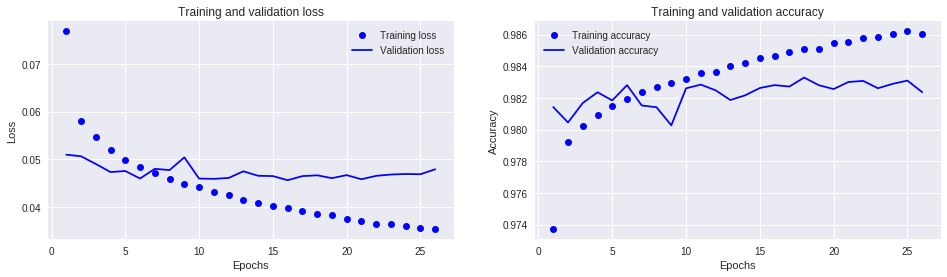

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 43s 1ms/step
([0.04599589166897809, 0.9825369321625752], 0.9827176615509116)
